In this project, I'm going to do the following 6 steps.

- Problem Definition
    > How can we predict the female births in California for the next day?
    
- Data Exploration
    > Given the daily female births in California in 1959, what can we explore from the dataset?
    
- Model Selection
    > How to choose a model and gather evidence and support to defend the decision
    
- Model Finalization
    > Train the chosen model on all available data and save it for later use
    
- Forecasting
    > Load the saved model and make a forecast.

- Model Update
    > Update the current model with the presence of new observations


## Step 1: Get familiar with the Daily Female Births Dataset

In [1]:
from pandas import read_csv
from matplotlib import pyplot

In [4]:
# read the dataset
femaleBirths = read_csv('daily_total_female_births.csv', header=0, index_col=0)
print(femaleBirths.head())

            Births
Date              
1959-01-01      35
1959-01-02      32
1959-01-03      30
1959-01-04      31
1959-01-05      44


In [13]:
femaleBirths.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


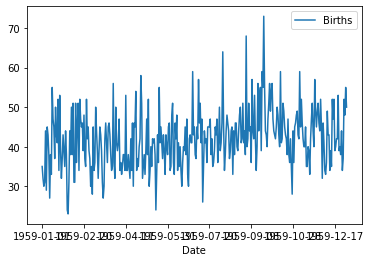

In [6]:
femaleBirths.plot()
pyplot.show()

In [16]:
# Now we try to change the date format in the above graph
femaleBirths.index

Index(['1959-01-01', '1959-01-02', '1959-01-03', '1959-01-04', '1959-01-05',
       '1959-01-06', '1959-01-07', '1959-01-08', '1959-01-09', '1959-01-10',
       ...
       '1959-12-22', '1959-12-23', '1959-12-24', '1959-12-25', '1959-12-26',
       '1959-12-27', '1959-12-28', '1959-12-29', '1959-12-30', '1959-12-31'],
      dtype='object', name='Date', length=365)

In [17]:
# conver the object index to datetime index
femaleBirths.index = pd.to_datetime(femaleBirths.index)

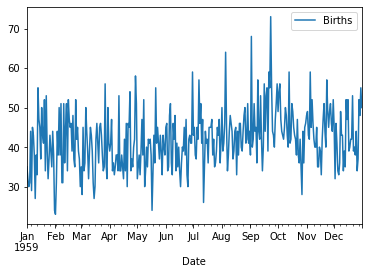

In [22]:
femaleBirths_ts = femaleBirths.resample('D').max() # 'D' means 'Day', 'W' means 'Week', etc.

ax = femaleBirths_ts.plot()

plt.show()

<ipython-input-23-f085216d0d6a>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))


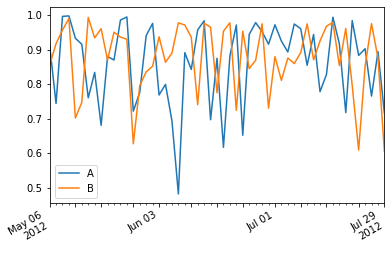

In [23]:
# Another example to change date formate

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker

start = pd.to_datetime("5-1-2012")
idx = pd.date_range(start, periods=365)
df = pd.DataFrame({'A': np.random.random(365), 'B': np.random.random(365)})
df.index = idx
df_ts = df.resample('W').max()

ax = df_ts.plot()

# plt.show()

# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*len(df_ts.index)
# Every 4th ticklable shows the month and day
ticklabels[::4] = [item.strftime('%b %d') for item in df_ts.index[::4]]
# Every 12th ticklabel includes the year
ticklabels[::12] = [item.strftime('%b %d\n%Y') for item in df_ts.index[::12]]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
plt.gcf().autofmt_xdate()

plt.show()

## Step 2: Select Time Series Forecast Model

Firstly, we can arbitrarily select an **autoregression model (AR)** with a lag of 6 on the differenced dataset.

The data is transformed by differencing. And the AR(6) model is trained on 66% of the historical data. 

The regression coefficients learned by the model are extracted and used to make predictions in a **rolling** manner across the test dataset.

As each time step in the test dataset is executed, the prediction is made using the coefficients and stored. The actual observation for the time step is then made available and stored to be used as a lag variable for future predictions.

In [24]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import numpy
from math import sqrt

In [25]:
# create a difference transform of the dataset
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return numpy.array(diff)

In [26]:
# Make a prediction give regression coefficients and lag obs
def predict(coef, history):
    yhat = coef[0]
    for i in range(1, len(coef)):
        yhat += coef[i] * history[-i]
    return yhat

In [29]:
# read the data
femaleBirths = read_csv('daily_total_female_births.csv', header=0, index_col=0, parse_dates=True)

In [31]:
# split dataset
X = difference(femaleBirths.values)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:]

In [32]:
# fit and evaluate an AR model

# train autoregression
window = 6
model = AutoReg(train, lags=6)
model_fit = model.fit()
coef = model_fit.params

In [33]:
# walk forward over time steps in test
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
    yhat = predict(coef, history)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)

In [38]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# the Root Mean Squared Error (RMSE) of the predictions is about 7 births on average

Test RMSE: 7.259


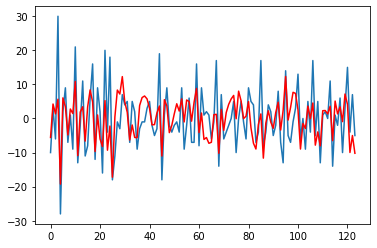

In [35]:
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# a graph is created showing the actual observations in the test dataset (blue) compared to the predictions (red)

In [37]:
predictions[:10]

[array([-5.56338215]),
 array([4.2442818]),
 array([1.35986927]),
 array([5.65659183]),
 array([-19.24108074]),
 array([6.05143194]),
 array([3.46413147]),
 array([-4.81630908]),
 array([2.77762143]),
 array([1.45524222])]

## Step 3: Finalize and Save Time Series Forecast Model

Once the model is selected, we must finalize it.

This means we need to save the salient information learned by the model so that we do not have to re-create it every time a prediction is needed.

This involves first training the model on all available data and then saving the model to file.

The `statsmodels` implementations of time series models do provide built-in capability to save and load models by calling `save()` and `load()` on the fit AutoRegResults object.

For example, the code below will train an AR(6) model on the entire dataset and save it using the built-in `save()` function, which will essentially pickle the **AutoRegResults** object.

The differenced training data must also be saved, both for the lag variables needed to make a prediction, and for knowledge of the number of observations seen, required by the `predict()` function of the **AutoRegResults** object.

Finally, we need to be able to transform the differenced dataset back into the original form. To do this, we must keep track of the last actual observation. This is so that the predicted differenced value can be added to it.

In [39]:
from pandas import read_csv
from statsmodels.tsa.ar_model import AutoReg
import numpy

In [40]:
# fit an AR model and save the whole model to file

X = difference(femaleBirths.values)

# fit model with the whole dataset
model = AutoReg(X, lags=6)
model_fit = model.fit()

In [42]:
# save model to file
model_fit.save('ar_model.pkl')

# save the differenced dataset
numpy.save('ar_data.npy', X)

# save the last ob
numpy.save('ar_obs.npy', [femaleBirths.values[-1]])

This code will create a file ar_model.pkl that we can load later and use to make predictions.

The entire training dataset is saved as ar_data.npy and the last observation is saved in the file ar_obs.npy as an array with one item.

The NumPy `save()` function is used to save the differenced training data and the observation. The `load()` function can then be used to load these arrays later.

Now let's load the model, differenced data, and last observation.

In [43]:
from statsmodels.tsa.ar_model import AutoRegResults
import numpy

In [44]:
loaded = AutoRegResults.load('ar_model.pkl')
print(loaded.params)

[ 0.12129822 -0.75275857 -0.612367   -0.51097172 -0.4176669  -0.32116469
 -0.23412997]


In [45]:
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')
print(last_ob)

[[50]]


We can also simply store the model coefficients and later load them and make predictions.

To be more specific, we can just save the coefficients from the model, as well as the minimum differenced lag values required to make the next prediction and the last observation needed to transform the next prediction made.

In [46]:
# save coefficients
coef = model_fit.params
numpy.save('man_model.npy', coef)

In [48]:
# save lag
window_size = 6
lag = X[-window_size:]
numpy.save('man_data.npy', lag)

In [50]:
# save the last ob
numpy.save('man_obs.npy', [femaleBirths.values[-1]])

The coefficients are saved in the local file *man_model.npy*, the lag history is saved in the file *man_data.npy*, and the last observation is saved in the file *man_obs.npy*.

These values can then be loaded again as follows.

In [52]:
# load the manually saved model from file
import numpy
coef = numpy.load('man_model.npy')
print(coef)

[ 0.12129822 -0.75275857 -0.612367   -0.51097172 -0.4176669  -0.32116469
 -0.23412997]


In [53]:
lag = numpy.load('man_data.npy')
print(lag)

[[-10]
 [  3]
 [ 15]
 [ -4]
 [  7]
 [ -5]]


In [54]:
last_ob = numpy.load('man_obs.npy')
print(last_ob)

[[50]]


Running this example prints the loaded data for review. We can see the coefficients and last observation match the output from the previous example.

Now that we know how to save a finalized model, we can use it to make forecasts.

## Step 4: Make a Time Series Forecast

Making a forecast involves loading the saved model and estimating the observation at the next time step.

If the **AutoRegResults** object was serialized, we can use the `predict()` function to predict the next time period.

The example below shows how the next time period can be predicted.

The model, training data, and last observation are loaded from file.

The period is specified to the `predict()` function as the next time index after the end of the training data set. This index may be stored directly in a file instead of storing the entire training data, which may be an efficiency.

The prediction is made, which is in the context of the differenced dataset. To turn the prediction back into the original units, it must be added to the last known observation.

In [55]:
from statsmodels.tsa.ar_model import AutoRegResults
import numpy

In [56]:
# load model
model = AutoRegResults.load('ar_model.pkl')
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')

# make prediction
predictions = model.predict(start=len(data), end=len(data))

# transform prediction
yhat = predictions[0] + last_ob[0]
print('Prediction: %f' % yhat)

Prediction: 46.755211


We can also use a similar trick to load the raw coefficients and make a manual prediction.

In [57]:
# load a coefficients and from file and make a manual prediction
import numpy
 
# load model
coef = numpy.load('man_model.npy')
lag = numpy.load('man_data.npy')
last_ob = numpy.load('man_obs.npy')

# make prediction
prediction = predict(coef, lag)

# transform prediction
yhat = prediction + last_ob[0]
print('Prediction: %f' % yhat)

Prediction: 46.755211


Running the example, we achieve the same prediction as we would expect, given the underlying model and method for making the prediction are the same.

## Step 5: Update Forecast Model

Once the next real observation is made available, we must update the data associated with the model.

Specifically, we must update:

- The differenced training dataset used as inputs to make the subsequent prediction.
- The last observation, providing a context for the predicted differenced value.

Let’s assume the next actual observation in the series was *48*.

The new observation must first be differenced with the last observation. It can then be stored in the list of differenced observations. Finally, the value can be stored as the last observation.

In the case of the stored AR model, we can update the *ar_data.npy* and *ar_obs.npy* files. 

In [58]:
# update the data for the AR model with a new obs
import numpy

# get real observation
observation = 48

# load the saved data
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')

# update and save differenced observation
diffed = observation - last_ob[0]
data = numpy.append(data, [diffed], axis=0)
numpy.save('ar_data.npy', data)

# update and save real observation
last_ob[0] = observation
numpy.save('ar_obs.npy', last_ob)

We can make the same changes for the data files for the manual case. Specifically, we can update the *man_data.npy* and *man_obs.npy* respectively.

In [59]:
# update the data for the manual model with a new obs
import numpy

# get real observation
observation = 48

# update and save differenced observation
lag = numpy.load('man_data.npy')
last_ob = numpy.load('man_obs.npy')
diffed = observation - last_ob[0]
lag = numpy.append(lag[1:], [diffed], axis=0)
numpy.save('man_data.npy', lag)

# update and save real observation
last_ob[0] = observation
numpy.save('man_obs.npy', last_ob)

We have focused on *one-step forecasts*.

These methods would work just as easily for multi-step forecasts, by using the model repetitively and using forecasts of previous time steps as input lag values to predict observations for subsequent time steps.

### Notes: Consider Storing All Observations
Generally, it is a good idea to keep track of all the observations.

This will allow us to:

- Provide a context for further time series analysis to understand new changes in the data.
- Train a new model in the future on the most recent data.
- Back-test new and different models to see if performance can be improved.

## Summary

Through this project, we have learned how to finalize a time series model and use it to make predictions with Python.

Specifically, we learned:

- How to save a time series forecast model to file
- How to load a saved time series forecast from file and make a prediction
- How to update a time series forecast model with new observations